In [1]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git
! pip install seqeval
! pip install sklearn_crfsuite

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-o3zfvfc5
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-o3zfvfc5
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=a72847e0ecda287912b624c968638cc228fbd2f5b95175a7d05b919fff7f03d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-1n54aksw/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=0c1db6a6dfed2221e5285795214bd50f7bca759b1e70e1c9e0a87c2f8cd97a22
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
     |████████████████████████████████| 747kB 7.8MB/s 


In [2]:
import pandas as pd 
import numpy as np
from math import nan
from future.utils import iteritems
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
#loading train data
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive//My Drive/entity_train.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19,20,24,25,32,33,47,48,49,50,51,52,53,54,60,61,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df[2020:2030]

,Sentence ID,type,CUI,Preferred name,Semantic Type,Text,Confidence Score,First char pos,Last char pos,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
2020,30.0,entity,C0232693,Bowel sounds,fndg,bowel sounds,901,2296,2308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,30.0,entity,C0038002,Splenomegaly,fndg,splenomegaly,861,2322,2334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022,30.0,entity,C1306372,"Mass, a measure of quantity of matter",qnco,masses,966,2340,2346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024,31.0,text,2348,2396,"Extremities; no clubbing , cyanosis , or edema.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,31.0,entity,C0015385,Limb structure,bpoc,Extremities,1000,2348,2359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026,31.0,entity,C0009080,Clubbed Fingers,anab,clubbing,1000,2364,2372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,31.0,entity,C0010520,Cyanosis,sosy,cyanosis,1000,2375,2383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028,31.0,entity,C0013604,Edema,sosy,edema,1000,2389,2394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df1=df[['type','Sentence ID','Text','Semantic Type']]

df1=df1[df1['type']=='entity']  #We take only the entities i.e. removing the text and relation types

df1=df1[['Sentence ID','Text','Semantic Type']]

df1=df1.rename(columns={'Sentence ID':'sentence_idx','Text':'word','Semantic Type':'tag'})

In [6]:
df1[2030:2040]

,sentence_idx,word,tag
2784,21.0,right,spco
2785,21.0,radial artery,bpoc
2786,21.0,clean,acty
2787,21.0,coronary arteries,bpoc
2790,22.0,numbness,fndg
2791,22.0,tingling,dsyn
2792,22.0,good,qlco
2793,22.0,motion,npop
2796,23.0,Patient,podg
2797,23.0,PCP,dsyn


In [7]:
#loading test data
from google.colab import drive
drive.mount('/content/drive')
dftest=pd.read_csv('/content/drive//My Drive/entity_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
dftest[2040:2050]

,Sentence ID,type,CUI,Preferred name,Semantic Type,Text,Confidence Score,First char pos,Last char pos,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
2040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2041,42.0,text,2388,2409,Amount unspecified .,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2042,42.0,entity,C1265611,Quantity,qnco,Amount,1000.0,2388.0,2394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2043,42.0,entity,C0205370,Unspecified,qlco,unspecified,1000.0,2395.0,2406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2045,43.0,text,2409,2444,Lives with her husband in Bayont .,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2046,43.0,entity,C0595998,Household composition,fndg,Lives,1000.0,2409.0,2414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,43.0,entity,C0242664,husband,famg,husband,1000.0,2424.0,2431.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2049,44.0,text,2444,2485,PHYSICAL EXAMINATION : She is afebrile .,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
dftest1=dftest[['type','Sentence ID','Text','Semantic Type']]

dftest1=dftest1[dftest1['type']=='entity']  #We take only the entities i.e. removing the text and relation

dftest1=dftest1[['Sentence ID','Text','Semantic Type']]

dftest1=dftest1.rename(columns={'Sentence ID':'sentence_idx','Text':'word','Semantic Type':'tag'})

In [10]:
dftest1[2040:2050]

,sentence_idx,word,tag
3201,13.0,spinal cord,bpoc
3202,13.0,urgent,tmco
3203,13.0,neurosurgery,topp
3204,13.0,intervention,topp
3208,14.0,MRI,diap
3209,14.0,frontal,spco
3210,14.0,cerebellar hemorrhagic,patf
3211,14.0,enhancing lesions,fndg
3212,14.0,extensive,qlco
3213,14.0,intracranial,blor


In [0]:
###creating sentence id

#for train data

index_train=df1.index


seq_train=[]
seq_train.append(df1['sentence_idx'][index_train[0]])
for i in range(1,len(index_train)):
  seq_train.append(df1['sentence_idx'][index_train[i]]-df1['sentence_idx'][index_train[i-1]])
len(seq_train)


neg_ind_train=[]
for i in range(len(seq_train)):
  if seq_train[i]<0:
    seq_train[i]=1
    neg_ind_train.append(i)

df1=df1.assign(ind_train=seq_train)
sen_id=df1['ind_train'].cumsum()
df1=df1.assign(sentence_idx=sen_id)
df1=df1.drop('ind_train',1)
df1=df1.dropna()

In [12]:
df1[2040:2050]

,sentence_idx,word,tag
2798,333.0,cause,ftcn
2801,334.0,note,clna
2802,334.0,intermittent diarrhea,sosy
2803,334.0,several,qnco
2804,334.0,weeks,tmco
2805,334.0,in house,idcn
2806,334.0,episodes,tmco
2807,334.0,watery brown diarrhea,sosy
2808,334.0,trace,qlco
2809,334.0,guaiac positive,lbtr


In [13]:
df1.head()

,sentence_idx,word,tag
1,1.0,RECORD,inpr
2,1.0,10/2006 12,fndg
3,1.0,CORONARY ARTERY DISEASE,dsyn
4,1.0,Signed,inpr
5,1.0,DIS,inpr


In [14]:
df1.tail()

,sentence_idx,word,tag
397346,55259.0,outpatient,podg
397347,55259.0,cardiologist,prog
397350,55260.0,document,inpr
397351,55260.0,Tel,gngm
397352,55260.0,end,spco


In [0]:
#creating sentence id for test data

index_test=dftest1.index


seq_test=[]
seq_test.append(dftest1['sentence_idx'][index_test[0]])
for i in range(1,len(index_test)):
  seq_test.append(dftest1['sentence_idx'][index_test[i]]-dftest1['sentence_idx'][index_test[i-1]])
len(seq_test)


neg_ind_test=[]
for i in range(len(seq_test)):
  if seq_test[i]<0:
    seq_test[i]=1
    neg_ind_test.append(i)

dftest1=dftest1.assign(ind_test=seq_test)
sen_id=dftest1['ind_test'].cumsum()
dftest1=dftest1.assign(sentence_idx=sen_id)
dftest1=dftest1.drop('ind_test',1)
dftest1=dftest1.dropna()

In [16]:
dftest1[2040:2050]

,sentence_idx,word,tag
3201,537.0,spinal cord,bpoc
3202,537.0,urgent,tmco
3203,537.0,neurosurgery,topp
3204,537.0,intervention,topp
3208,538.0,MRI,diap
3209,538.0,frontal,spco
3210,538.0,cerebellar hemorrhagic,patf
3211,538.0,enhancing lesions,fndg
3212,538.0,extensive,qlco
3213,538.0,intracranial,blor


In [17]:
dftest1.head()

,sentence_idx,word,tag
1,1.0,ROOT,plnt
2,1.0,RECORD,inpr
3,1.0,ID,dsyn
4,1.0,TEXT,inpr
5,1.0,FIH,dsyn


In [18]:
dftest1.tail()

,sentence_idx,word,tag
245376,34801.0,M.D,inpr
245379,34802.0,end,spco
245380,34802.0,TEXT,inpr
245381,34802.0,RECORD,inpr
245382,34802.0,ROOT,plnt


In [0]:
#Split test data into 2 half
test_sp1, test_sp2 = train_test_split(dftest1, test_size=0.5,random_state=123)

In [20]:
max(df1['sentence_idx'])

55260.0

In [21]:
max(dftest1['sentence_idx'])

34802.0

In [0]:
dfdev1, test_sp = train_test_split(test_sp2, test_size=0.5,random_state=123)	#Split other half test data into dev and test data
dfdev1=dfdev1.sort_index(axis=0)
test_sp=test_sp.sort_index(axis=0)
dftest1=test_sp

In [23]:
dftest1[2040:2050]

,sentence_idx,word,tag
12349,1938.0,anuric,dsyn
12355,1938.0,rheumatic fever,dsyn
12362,1939.0,replacement,topp
12371,1940.0,brain,bpoc
12372,1940.0,magnetic resonance imaging study,diap
12374,1940.0,scan,diap
12382,1940.0,cardiac ultrasound,diap
12383,1940.0,sternum,bpoc
12385,1940.0,exploration,topp
12391,1941.0,PRESENT ILLNESS,fndg


In [24]:
dfdev1[2010:2020]

,sentence_idx,word,tag
12270,1921.0,local,spco
12276,1922.0,conference,hcpp
12299,1927.0,doctor,prog
12302,1928.0,M.D,inpr
12305,1929.0,M .D,inpr
12326,1935.0,RECORD,inpr
12328,1935.0,TEXT,inpr
12334,1936.0,DISCHARGE DATE,tmco
12339,1937.0,Acute polymicrobial bacterial endocarditis,dsyn
12343,1938.0,aortic dissection,patf


In [25]:
#Taking only required tags and the rest renamed as others 'O'
tag_req=['diap','fndg','lbpr','lbtr']
df2=df1[df1.tag.str.contains('|'.join(tag_req))]

req_train=df2.index

for i in df1.index:
  if i not in req_train:
    df1.tag[i]='O'
  else:
    if ',' in df1.tag[i]:
      df1.tag[i]='O'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [26]:
dftest2=dftest1[dftest1.tag.str.contains('|'.join(tag_req))]

req_test=dftest2.index

for i in dftest1.index:
  if i not in req_test:
    dftest1.tag[i]='O'
  else:
    if ',' in dftest1.tag[i]:
      dftest1.tag[i]='O'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [27]:
dfdev2=dfdev1[dfdev1.tag.str.contains('|'.join(tag_req))]

req_dev=dfdev2.index

for i in dfdev1.index:
  if i not in req_dev:
    dfdev1.tag[i]='O'
  else:
    if ',' in dfdev1.tag[i]:
      dfdev1.tag[i]='O'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [33]:
df1[2010:2020]

,sentence_idx,word,tag
2750,324.0,teeth,O
2753,325.0,racing heart,fndg
2754,325.0,dyspnea,O
2757,326.0,Somewhat better,O
2758,326.0,NTG,O
2759,326.0,SL NTG x 3,O
2762,327.0,Completely,O
2765,328.0,pain free,O
2766,328.0,EKG changes,fndg
2767,328.0,TnI,O


In [34]:
dftest1[780:790]

,sentence_idx,word,tag
4897,799.0,anemia,O
4898,799.0,hematocrit,lbpr
4900,799.0,microcytic,fndg
4906,800.0,positive,O
4913,801.0,chest,O
4919,802.0,Liver,O
4929,804.0,tomographic,diap
4932,804.0,thickening,fndg
4936,804.0,lesser,O
4942,805.0,thickening,fndg


In [35]:
dfdev1[200:210]

,sentence_idx,word,tag
1253,191.0,chemotherapy,O
1258,192.0,head CT,diap
1269,194.0,echocardiogram,diap
1281,196.0,symptoms,O
1282,196.0,dyspnea,O
1290,198.0,Schizoaffective disorder,O
1304,203.0,ALLERGIES,O
1307,204.0,Penicillin,O
1321,208.0,Erythromycin,O
1328,210.0,Talwin,O


In [0]:
#BIO-tagging For Train Data
temp01=pd.DataFrame(df1.word.str.split().tolist(), index=df1['sentence_idx']).stack()
d1 = temp01.index
t1 = []
for i in range(len(d1)):
  if d1[i][1] == 0:
    t1.append('B-')
  else:
    t1.append('I-')
temp01 = temp01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp01.columns = ['word','sentence_idx']
temp01=temp01[['sentence_idx','word']]
temp01=temp01.assign(bio_tr=t1)

temp02=pd.DataFrame(df1.word.str.split().tolist(), index=df1['tag']).stack()
temp02 = temp02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp02.columns = ['word','tag']

temp01["tag"] = temp01["bio_tr"].astype(str) + temp02["tag"]
del temp01['bio_tr']
temp01['tag']=temp01['tag'].replace(['B-O','I-O'],'O')

df1=temp01

In [38]:
df1[2150:2160]

,sentence_idx,word,tag
2150,269.0,abdomen,O
2151,269.0,adenopathy,O
2152,269.0,evidence,O
2153,269.0,metastasis,O
2154,269.0,IVC,B-diap
2155,269.0,dilatation,O
2156,269.0,approximately,O
2157,270.0,PAST,B-fndg
2158,270.0,MEDICAL,I-fndg
2159,270.0,HISTORY,I-fndg


In [0]:
#BIO-tagging For Test Data
temp_test01=pd.DataFrame(dftest1.word.str.split().tolist(), index=dftest1['sentence_idx']).stack()
d1_test = temp_test01.index
t1_test = []
for i in range(len(d1_test)):
  if d1_test[i][1] == 0:
    t1_test.append('B-')
  else:
    t1_test.append('I-')
temp_test01 = temp_test01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp_test01.columns = ['word','sentence_idx']
temp_test01=temp_test01[['sentence_idx','word']]
temp_test01=temp_test01.assign(bio_te=t1_test)

temp_test02=pd.DataFrame(dftest1.word.str.split().tolist(), index=dftest1['tag']).stack()
temp_test02 = temp_test02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp_test02.columns = ['word','tag']

temp_test01["tag"] = temp_test01["bio_te"].astype(str) + temp_test02["tag"]
del temp_test01['bio_te']
temp_test01['tag']=temp_test01['tag'].replace(['B-O','I-O'],'O')

dftest1=temp_test01

In [40]:
dftest1[285:295]

,sentence_idx,word,tag
285,240.0,Metabolic,B-lbpr
286,240.0,20,I-lbpr
287,240.0,panel,I-lbpr
288,240.0,unremarkable,O
289,241.0,unremarkable,O
290,242.0,normal,B-fndg
291,242.0,sinus,I-fndg
292,242.0,rhythm,I-fndg
293,243.0,patient,O
294,245.0,time,O


In [0]:
#BIO-tagging For dev Data
temp_dev01=pd.DataFrame(dfdev1.word.str.split().tolist(), index=dfdev1['sentence_idx']).stack()
d1_dev = temp_dev01.index
t1_dev = []
for i in range(len(d1_dev)):
  if d1_dev[i][1] == 0:
    t1_dev.append('B-')
  else:
    t1_dev.append('I-')
temp_dev01 = temp_dev01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp_dev01.columns = ['word','sentence_idx']
temp_dev01=temp_dev01[['sentence_idx','word']]
temp_dev01=temp_dev01.assign(bio_te=t1_dev)

temp_dev02=pd.DataFrame(dfdev1.word.str.split().tolist(), index=dfdev1['tag']).stack()
temp_dev02 = temp_dev02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp_dev02.columns = ['word','tag']

temp_dev01["tag"] = temp_dev01["bio_te"].astype(str) + temp_dev02["tag"]
del temp_dev01['bio_te']
temp_dev01['tag']=temp_dev01['tag'].replace(['B-O','I-O'],'O')

dfdev1=temp_dev01

In [42]:
dfdev1[285:295]

,sentence_idx,word,tag
285,224.0,SOCIAL,B-fndg
286,224.0,HISTORY,I-fndg
287,225.0,boyfriend,O
288,226.0,siblings,O
289,227.0,patient,O
290,227.0,20,O
291,227.0,pack,O
292,227.0,smoking,B-fndg
293,227.0,history,I-fndg
294,229.0,drug,O


In [0]:
train=df1
test=dftest1
dev=dfdev1

In [0]:
#Define Sentence Getter
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
#Sentence getter for train
getter_train = SentenceGetter(train)
sentences_train = getter_train.sentences

#Sentence getter for test
getter_test = SentenceGetter(test)
sentences_test = getter_test.sentences

#Sentence getter for dev
getter_dev = SentenceGetter(dev)
sentences_dev = getter_dev.sentences

In [48]:
sentences_test[285:290]

[[('HOSPITAL', 'O'), ('COURSE', 'O')],
 [('coronary', 'O'),
  ('artery', 'O'),
  ('bypass', 'O'),
  ('grafting', 'O'),
  ('obtuse', 'O'),
  ('left', 'O'),
  ('anterior', 'O'),
  ('descending', 'O')],
 [('surgeon', 'O')],
 [('Further', 'O'), ('Stepdown', 'O'), ('Unit', 'O')],
 [('diet', 'O'), ('physical', 'O'), ('activity', 'O')]]

In [0]:
##formation of words and tags

#for train

words_train = list(set(train["word"].values))
n_words_train = len(words_train)

tags_train = []
for tag in set(train["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_train.append('unk')
    else:
        tags_train.append(tag)
n_tags_train = len(tags_train)

#for test
words_test = list(set(test["word"].values))
n_words_test = len(words_test)

tags_test = []
for tag in set(test["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_test.append('unk')
    else:
        tags_test.append(tag)
n_tags_test = len(tags_test)

#for dev
words_dev = list(set(dev["word"].values))
n_words_dev = len(words_dev)

tags_dev = []
for tag in set(dev["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_dev.append('unk')
    else:
        tags_dev.append(tag)
n_tags_dev = len(tags_dev)

In [0]:
#taking union of train, dev and test

words_all = list(set().union(words_train,words_test,words_dev))
n_words_all = len(words_all)

tags_all = list(set().union(tags_train,tags_test,tags_dev))
n_tags_all = len(tags_all)

In [0]:
##formation of word2id, tag2id and id2tag

#for all union of train and test
word2idx_all = {w: i for i, w in enumerate(words_all)}
tag2idx_all = {t: i for i, t in enumerate(tags_all)}
idx2tag_all = {v: k for k, v in iteritems(tag2idx_all)}

maxlen_all = max(max([len(s) for s in sentences_train]),max([len(s) for s in sentences_test]),max([len(s) for s in sentences_dev]))

In [52]:
words_all[25:35]

['MOFETIL',
 'prom',
 'LV',
 'HYDROPHILIC',
 'retroperitoneum',
 'Course',
 'pulmonologist',
 'LON',
 'PE-CT',
 'African-']

In [53]:
tags_all

['B-fndg',
 'I-lbpr',
 'B-lbpr',
 'I-lbtr',
 'B-lbtr',
 'I-fndg',
 'I-diap',
 'B-diap',
 'O']

In [54]:
tag2idx_all

{'B-diap': 7,
 'B-fndg': 0,
 'B-lbpr': 2,
 'B-lbtr': 4,
 'I-diap': 6,
 'I-fndg': 5,
 'I-lbpr': 1,
 'I-lbtr': 3,
 'O': 8}

In [55]:
idx2tag_all

{0: 'B-fndg',
 1: 'I-lbpr',
 2: 'B-lbpr',
 3: 'I-lbtr',
 4: 'B-lbtr',
 5: 'I-fndg',
 6: 'I-diap',
 7: 'B-diap',
 8: 'O'}

In [0]:
##vectorisation

#for train

maxlen_train = max([len(s) for s in sentences_train])

X_train = [[word2idx_all[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen=maxlen_all, sequences=X_train, padding="post",value=n_words_all - 1)

y_train = [[tag2idx_all[w[1]] for w in s] for s in sentences_train]
y_train = pad_sequences(maxlen=maxlen_all, sequences=y_train, padding="post", value=tag2idx_all["O"])
y_train = [to_categorical(i, num_classes=n_tags_all) for i in y_train]


#for test
maxlen_test = max([len(s) for s in sentences_test])

X_test = [[word2idx_all[w[0]] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen=maxlen_all, sequences=X_test, padding="post",value=n_words_all - 1)

y_test = [[tag2idx_all[w[1]] for w in s] for s in sentences_test]
y_test = pad_sequences(maxlen=maxlen_all, sequences=y_test, padding="post", value=tag2idx_all["O"])
y_test = [to_categorical(i, num_classes=n_tags_all) for i in y_test]

#for dev
maxlen_dev = max([len(s) for s in sentences_dev])

X_dev = [[word2idx_all[w[0]] for w in s] for s in sentences_dev]
X_dev = pad_sequences(maxlen=maxlen_all, sequences=X_dev, padding="post",value=n_words_all - 1)

y_dev = [[tag2idx_all[w[1]] for w in s] for s in sentences_dev]
y_dev = pad_sequences(maxlen=maxlen_all, sequences=y_dev, padding="post", value=tag2idx_all["O"])
y_dev = [to_categorical(i, num_classes=n_tags_all) for i in y_dev]

In [57]:
X_train

array([[11984,  9159, 12855, ..., 19404, 19404, 19404],
       [ 9010, 12670, 17700, ..., 19404, 19404, 19404],
       [17183, 11937,  8975, ..., 19404, 19404, 19404],
       ...,
       [ 6923, 14344, 19404, ..., 19404, 19404, 19404],
       [ 6923, 17210, 19404, ..., 19404, 19404, 19404],
       [  602,  1031, 17505, ..., 19404, 19404, 19404]], dtype=int32)

In [58]:
y_train[0:3]

[array([[0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)]

In [0]:
##MODEL

input = Input(shape=(max(X_train.shape[1],X_dev.shape[1],X_test.shape[1]),))
word_embedding_size = 180

# Embedding Layer
model = Embedding(input_dim=n_words_all, output_dim=word_embedding_size, input_length=max(X_train.shape[1],X_dev.shape[1],X_test.shape[1]))(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags_all, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags_all)

out = crf(model)  # output
model = Model(input, out)

In [60]:
##FIT MODEL

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 274)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 274, 180)          3492900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 274, 360)          519840    
_________________________________________________________________
lstm_2 (LSTM)                (None, 274, 360)          1038240   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 274, 9)            3249      
_________________________________________________________________
crf_1 (CRF)                  (None, 274, 9)            189       
Total params: 5,054,418
Trainable params: 5,054,418
Non-trainable params: 0
_________________________________________________

In [0]:
# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [62]:
# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_data=(X_dev, np.array(y_dev)), verbose=1, callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 49758 samples, validate on 20655 samples
Epoch 1/20
49758/49758 [==============================] - 621s 12ms/step - loss: 0.0921 - crf_viterbi_accuracy: 0.9670 - accuracy: 0.0014 - val_loss: 0.0084 - val_crf_viterbi_accuracy: 0.9986 - val_accuracy: 0.9986

Epoch 00001: val_accuracy improved from -inf to 0.99864, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 2/20
49758/49758 [==============================] - 613s 12ms/step - loss: 0.0166 - crf_viterbi_accuracy: 0.9969 - accuracy: 0.0014 - val_loss: 0.0073 - val_crf_viterbi_accuracy: 0.9986 - val_accuracy: 0.9986

Epoch 00002: val_accuracy did not improve from 0.99864
Epoch 3/20
49758/49758 [==============================] - 612s 12ms/step - loss: 0.0143 - crf_viterbi_accuracy: 0.9969 - accuracy: 0.0014 - val_loss: 0.0057 - val_crf_viterbi_accuracy: 0.9986 - val_accuracy: 0.9986

Epoch 00003: val_accuracy improved from 0.99864 to 0.99864, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 4/20
49758/49758 [============

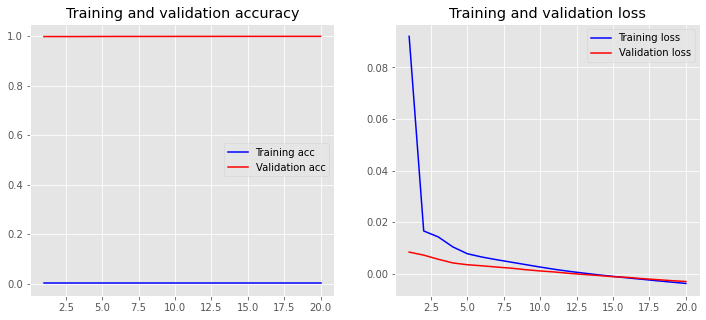

In [63]:
####PLOTS of loss and accuracy
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [64]:
####FIT with the TEST data
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag_all[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

20625/20625 [==============================] - 168s 8ms/step


In [65]:
#####REPORT of the fit

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

###Rest
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx_all.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag_all[gt[idx]],tags_all[pred])

for tag in tag2idx_all.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))

F1-score: 72.7%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      B-diap       0.83      0.74      0.78       878
      B-fndg       0.78      0.78      0.78      2971
      B-lbpr       0.82      0.83      0.82       443
      B-lbtr       0.75      0.05      0.10        59
      I-diap       0.79      0.60      0.68       470
      I-fndg       0.82      0.63      0.71      2520
      I-lbpr       0.65      0.62      0.63       208
      I-lbtr       0.00      0.00      0.00        72
           O       1.00      1.00      1.00   5643629

    accuracy                           1.00   5651250
   macro avg       0.72      0.58      0.61   5651250
weighted avg       1.00      1.00      1.00   5651250

tag:B-fndg
	 TN:         0	FP:         0
	 FN:         0	TP:     20625
tag:I-lbpr
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-lbpr
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-lbtr
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-lbtr
